# Basic Agent Sudy

It is recommended to have a look at the [0_basic_functionalities](0_basic_functionalities.ipynb), [1_Observation_Agents](1_Observation_Agents.ipynb), [2_Action_GridManipulation](3_TrainingAnAgent.ipynb) and [3_TrainingAnAgent](3_TrainingAnAgent.ipynb) notebooks before getting into this one.

**Objectives**

In this notebook we will expose how to study an Agent. For this notebook to be interested, we first use a dummy agent, and then we look at how to study his behaviour from the file saved.

This notebook will also show you how to use the Graphical User Interface built for analyzing grid2Op agents called "Grid2Viz".

It is more than recommended to know how to define an Agent and use a Runner before doing this tutotial!

## Evaluate the performance of a simple Agen

In [1]:
import os
import sys
import grid2op
import copy
import numpy as np
import shutil
import seaborn as sns
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from grid2op.Agent import PowerLineSwitch
from grid2op.Reward import L2RPNReward
from grid2op.Runner import Runner
from grid2op.Chronics import GridStateFromFileWithForecasts, Multifolder
path_agents = "study_agent_getting_started"
max_iter = 30

In the next cell we evaluate the agent "PowerLineSwitch" and save the results of this evaluation in "study_agent_getting_started"

In [ ]:
scoring_function = L2RPNReward
env = grid2op.make(reward_class=L2RPNReward)
# env.chronics_handler.set_max_iter(max_iter)
shutil.rmtree(os.path.abspath(path_agents), ignore_errors=True)
if not os.path.exists(path_agents):
    os.mkdir(path_agents)

# make a runner for this agent
path_agent = os.path.join(path_agents, "PowerLineSwitch")
shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)

runner = Runner(**env.get_params_for_runner(),
                agentClass=PowerLineSwitch
                )
res = runner.run(path_save=path_agent, nb_episode=2, 
                max_iter=max_iter,
                pbar=tqdm)
print("The results for the evaluated agent are:")
for _, chron_id, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

In [2]:
path_agent = os.path.join(path_agents, "PowerLineSwitch")

## Looking at the results, understand the behaviour of the Agent

The content of the folder is the following:

In [ ]:
!ls $path_agent

Now we can load the data corresponding to episode 1 for example, we can load the actions and the observations and de-serialize them properly into proper objects. This is now automatically done with the class "EpisodeData" that can be used as follow:

In [3]:
from grid2op.EpisodeData import EpisodeData
episode_studied = "001"
this_episode = EpisodeData.from_disk(path_agent, episode_studied)

## Inspect the actions

And now we can start to study the given agent, for example, let's inspect its actions and wonder how many powerlines it has disconnected (for example, this is probably not the best thing to do here...)

In [ ]:
line_disc = 0
line_reco = 0
for act in this_episode.actions:
    dict_ = act.as_dict() # representation of an action as a dictionnary, see the documentation for more information
    if "change_line_status" in dict_:
        if "set_bus_vect" in dict_:
            line_reco += 1
        else:
            line_disc +=  1
line_disc

We can also wonder how many times this Agent acted on the powerline with id $14$, and inspect how many times it has change its status:

In [ ]:
id_line_inspected = 14
line_disconnected = 0
for act in this_episode.actions:
    dict_ = act.effect_on(line_id=id_line_inspected) # which effect has this action action on the substation with given id
    # other objects are: load_id, gen_id, line_id or substation_id
    if dict_['change_line_status'] or dict_["set_line_status"] != 0:
        line_disconnected += 1
line_disconnected

## Inspect the modification of the environment

For example, we might want to inspect the number of hazards and maintenance of a total scenario, to see how difficult it was.

In [ ]:
nb_hazards = 0
nb_maintenance = 0
for act in this_episode.env_actions:
    dict_ = act.as_dict() # representation of an action as a dictionnary, see the documentation for more information
    if "nb_hazards" in dict_:
        nb_hazards += 1
    if "nb_maintenance" in dict_:
        nb_maintenance += 1
nb_maintenance

## Inspect the observations

For example, let's look at the value consumed by load 1. For this cell to work, it requires plotly for displaying the results.

In [ ]:
import plotly.graph_objects as go
load_id = 1
# extract the data
val_load1 = np.zeros(len(li_observations))
for i, obs in enumerate(li_observations):
    dict_ = obs.state_of(load_id=load_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_load1[i] = dict_['p']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_load1))],
                                 y=val_load1)])
fig.update_layout(title="Consumption of load {}".format(load_id),
                 xaxis_title="Time step",
                 yaxis_title="Load (MW)")
fig.show()

Or the values of generator 3 (it's supposed to represent a solar energy source)

In [ ]:
gen_id = 4
# extract the data
val_lgen3 = np.zeros(len(li_observations))
for i, obs in enumerate(li_observations):
    dict_ = obs.state_of(gen_id=gen_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_lgen3[i] = dict_['p']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_lgen3))],
                                 y=val_lgen3)])
fig.update_layout(title="Production of generator {}".format(gen_id),
                 xaxis_title="Time step",
                 yaxis_title="Production (MW)")
fig.show()

In the same fashion, we might want to get the flows on powerline connecting bus 3 to bus 4 (without knowing its id by using the appropriate method of the observation_space):

In [ ]:
from_ = 3
to_ = 4
found_ids = observation_space.get_lines_id(from_=from_, to_=to_)
line_id = found_ids[0]

# extract the data
val_l3_4 = np.zeros(len(li_observations))
for i, obs in enumerate(li_observations):
    dict_ = obs.state_of(line_id=line_id) # which effect has this action action on the substation with id 1
    # other objects are: load_id, gen_id, line_id or substation_id
    # see the documentation for more information.
    val_l3_4[i] = dict_["origin"]['a']

# plot it
fig = go.Figure(data=[go.Scatter(x=[i for i in range(len(val_l3_4))],
                                 y=val_l3_4)])
fig.update_layout(title="Flow on powerline {} (going from {} to {})".format(line_id, from_, to_),
                 xaxis_title="Time step",
                 yaxis_title="Production (MW)")
fig.show()

## Quick display of a grid using an observation

Bellow you can find an example on how to plot a observation and the underlying powergrid. This is an example, the results doesn't look really great. It uses plotly and requires the layout of the grid (eg the coordinates of the substations) to be specified.

Note also that this code is not optimized at all.

/home/donnotben/Documents/Grid2Op_dev/getting_started/grid2op/Plot/Plotting.py:47: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



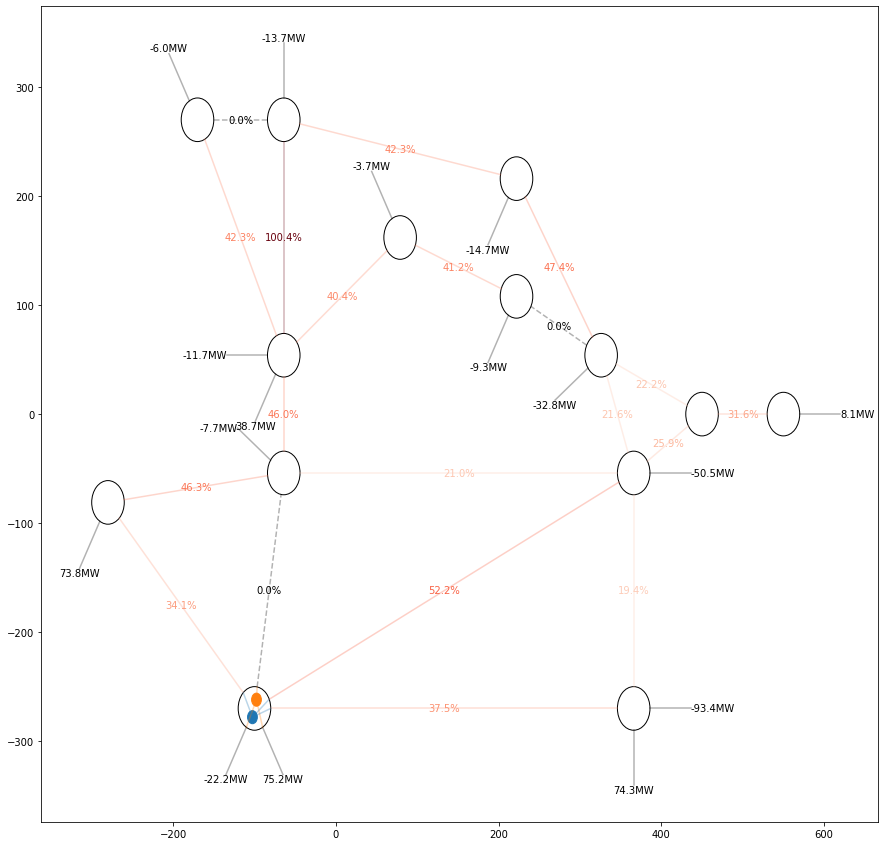

In [4]:
from grid2op.Plot import Plotting
obs = copy.deepcopy(this_episode.observations[-1])
# and change the topology (just to have something to represent)
obs.topo_vect[3:9] = [2,2,2,1,1,1]

plot_helper = Plotting(observation_space=this_episode.observation_space, display_mod="matplotlib")
fig = plot_helper.plot_obs(obs)

## Synching Observation and Action

As stated in the documentation, at row i, it's the observation at time "i" and the action at time "i". So at row i of the numpy matrices, we see what the agent saw when he took his actions. We have "an agent view".

In case we want to see the impact of an Action, it is then necessary to:

- look at action i
- look at observation i+1

## Using the dedicated grid2viz framework

Grid2viz is a package that has been developped to help you visualize the behaviour of your agent. 

It is available for now in a github repository [grid2viz](https://github.com/mjothy/grid2viz). In the few following cells we will demonstrate how to use it to inspect in more detail the log of the agents generated by the runner (second cell of this notebook).


We will first run some other agents to show the full potential of grid2viz (optional). Then we emphasize a constraint on the use of grid2viz: the folder tree must respect a certain order. Then we show how to install it and finally how to launch it on the data generated by this notebook.

![](https://raw.githubusercontent.com/mjothy/grid2viz/master/grid2viz/assets/screenshots/scenario_overview.png)

### More agents to compare

This section is not mandatory, but it is better to show the full capabilities of grid2viz. We will first run 2 others agents: the do nothing agent, and the topology greedy agents.

In [ ]:
# make a runner for this agent
from grid2op.Agent import DoNothingAgent, TopologyGreedy

for agentClass, agentName in zip([DoNothingAgent],  # , TopologyGreedy
                                 ["DoNothingAgent"]):  # , "TopologyGreedy"
    path_agent = os.path.join(path_agents, agentName)
    shutil.rmtree(os.path.abspath(path_agent), ignore_errors=True)
    runner = Runner(**env.get_params_for_runner(),
                    agentClass=agentClass
                    )
    res = runner.run(path_save=path_agent, nb_episode=2, 
                    max_iter=max_iter)
    print("The results for the {} agent are:".format(agentName))
    for _, chron_id, cum_reward, nb_time_step, max_ts in res:
        msg_tmp = "\tFor chronics with id {}\n".format(chron_id)
        msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
        msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
        print(msg_tmp)

### Caution

Grid2Viz for now require a specific organization of the folders. You must:
- use the runner to save the results of your experiment, using the "path_save" argument
- the agent must be "alone" in this directory: you should save it to an empty directory
- the path where the agent is stored must contain only folder of agents.

These contraints give the following "architecture":

+ regular directory
    + runner log
        + agent log 1
            - scenario log 1
            - scenario log 2
                ...
            - scenario log n
        + agent log 2
            - scenario log 1
                ...
            - scenario log p
        + agent log 3
            - scenario log 1
                ...
    + other folders
+ other folders

An example is given in the "path_agents" directory used in this notebook.

In [ ]:
!ls -R $path_agents

If the command "tree" is installed on your machine, you can uncomment the following cell to have a better layout.

In [ ]:
# !tree $path_agents

### Installation

Grid2Viz is not yet on pypi, the python package repository. So you need a specific command to install it. It can be done super easily by running the cell bellow (more information can be found on the grid2iz github).

In [ ]:
import sys
print("To install it, either uncomment the cell bellow, or type, in a command prompt:\n{}".format(
    ("\t{} -m pip install git+https://github.com/mjothy/grid2viz.git --user --extra-index-url https://test.pypi.org/simple/".format(sys.executable))))

In [ ]:
# !$sys.executable -m pip install git+https://github.com/mjothy/grid2viz --user --extra-index-url https://test.pypi.org/simple/

### Usage

Once the above package is installed, you can now start to study what your agent did (NB the agent must have been run with a runner and the "path_save" argument in order for grid2viz to work properly.

In [ ]:
print("You can start this server either by running the next cell, or by typing in a cmd:\n"\
      "\t\t{} -m grid2viz.main --path {}".format(sys.executable, os.path.abspath(path_agents)))

For performance optimization, grid2viz uses a cache. This notebook being an example, it is recommended to clear the cache before starting the grid2viz app. Of course, if you study different generation of your agent, it is NOT recommended to clear the cache before any study.

In [ ]:
shutil.rmtree(os.path.join(os.path.abspath(path_agents), "_cache"), ignore_errors=True)

In [5]:
!$sys.executable -m grid2viz.main --path=$path_agents

/usr/lib64/python3.6/runpy.py:125: RuntimeWarning: 'grid2viz.main' found in sys.modules after import of package 'grid2viz', but prior to execution of 'grid2viz.main'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
 * Serving Flask app "/home/donnotben/.local/lib/python3.6/site-packages/grid2viz/index.py"
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
the config file used is located at: /home/donnotben/Documents/Grid2Op_dev/getting_started/config.ini
Agents ata used are located at: /home/donnotben/Documents/Grid2Op_dev/getting_started/study_agent_getting_started
Data used are located at: /home/donnotben/Documents/Grid2Op_dev/getting_started/study_agent_getting_started
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Apr/2020 17:53:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:53:31] "GET /assets/loading.css?m=1583328724.0 HTTP/1.1" 304 -
127.0.0.1 - - [11/Apr/2020 17:53:31] "GET /asse

127.0.0.1 - - [11/Apr/2020 17:54:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:27] "POST /_dash-update-component HTTP/1.1" 204 -
127.0.0.1 - - [11/Apr/2020 17:54:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.

127.0.0.1 - - [11/Apr/2020 17:54:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2020 17:54:50] "POST /_dash-update-component HTTP/1.1" 200 -
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/donnotben/.local/lib/python3.6/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/donnotben/.local/lib/python3.6/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/donnotben/.local/lib/python3.6/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, e

^C
